In this notebook, we use `rose` to train a reduced basis method emulator in the offline stage, using binary local tangent subspace projection backed by `osiris::BinarySPTree`. This allows us to create a binary partition to our parameter space, so each linear space of scattering solutions (and EIM decomposition terms) that we project on only has to span the actual solutions of a small subvolume of our manifold, allowing us to approximate the fully-non-linear manifold of the scattering operator over a wide parameter space. 

We can think of this as a local method rather than a global method. Because each subvolume scales in volume with the binary tree depth $k$ as $(1/2)^k$, with a large enough depth, the unerlying manifold can be well-approximated as linear within the domain of each subvolume, assuming it is smooth. This is similar to liner interpolation over a data set, exept we're interpolating over a manifold that has as, its domain, a potentially high-dimensional parameter space, and, as its range, an instance of an operator acting on a Hilbert space (or, equivalently, a set of eigenfunctions of that operator).

In [1]:
# if we don't have it, we will need rose to handle the construction of the RBM emulator
# !pip install nuclear-rose

In [2]:
import rose

In [3]:
from osiris import BinarySPTree

In [4]:
# other things we'll need
import numpy as np
from pathlib import Path
import pickle
from tqdm import tqdm
import jitr
from numba import njit

In [5]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from rose.training import multiple_formatter

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
    }
)

In [6]:
def transform(sample):
    out = np.copy(sample)
    #out = np.log(out)
    return out

In [7]:
def inv_transform(sample):
    out = np.copy(sample)
    #out = np.exp(out)    
    return out

In [8]:
params = np.load("./global_kd_params.npy")
lower_bound = np.min(params, axis=(0, 1))
lower_bound[0] = 1e-1
upper_bound = np.max(params, axis=(0, 1))
bounds = np.vstack([lower_bound, upper_bound]).T

In [9]:
bounds

array([[ 1.00000000e-01,  5.00000000e+01],
       [ 9.27253291e+02,  9.83439040e+02],
       [ 3.24862646e+01,  5.09474947e+01],
       [ 5.11769037e+00,  6.88789256e+00],
       [ 6.51777500e-01,  6.66498800e-01],
       [ 8.71746944e-02,  4.80302097e+00],
       [ 5.11769037e+00,  6.88789256e+00],
       [ 6.51777500e-01,  6.66498800e-01],
       [ 2.67172625e+00,  6.73960839e+00],
       [ 5.40178569e+00,  7.01274719e+00],
       [ 5.15620000e-01,  5.32014400e-01],
       [ 4.85189971e+00,  6.27749683e+00],
       [ 4.37414528e+00,  5.98346936e+00],
       [ 5.90000000e-01,  5.90000000e-01],
       [-3.74068604e-01, -5.36334245e-03],
       [ 4.37414528e+00,  5.98346936e+00],
       [ 5.90000000e-01,  5.90000000e-01]])

In [10]:
bounds[0,:] = transform(bounds[0,:])
bounds

array([[ 1.00000000e-01,  5.00000000e+01],
       [ 9.27253291e+02,  9.83439040e+02],
       [ 3.24862646e+01,  5.09474947e+01],
       [ 5.11769037e+00,  6.88789256e+00],
       [ 6.51777500e-01,  6.66498800e-01],
       [ 8.71746944e-02,  4.80302097e+00],
       [ 5.11769037e+00,  6.88789256e+00],
       [ 6.51777500e-01,  6.66498800e-01],
       [ 2.67172625e+00,  6.73960839e+00],
       [ 5.40178569e+00,  7.01274719e+00],
       [ 5.15620000e-01,  5.32014400e-01],
       [ 4.85189971e+00,  6.27749683e+00],
       [ 4.37414528e+00,  5.98346936e+00],
       [ 5.90000000e-01,  5.90000000e-01],
       [-3.74068604e-01, -5.36334245e-03],
       [ 4.37414528e+00,  5.98346936e+00],
       [ 5.90000000e-01,  5.90000000e-01]])

In [11]:
# we will only partition space in the subset of parameters 
# that change by more than an order of magnitude
mask = upper_bound / lower_bound > 10

In [12]:
mask

array([ True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False])

In [13]:
parameters_suject_to_partitioning =  np.sum(mask)
print(parameters_suject_to_partitioning)

2


In [14]:
depth = parameters_suject_to_partitioning * 2+1
#depth=4
size = 2**depth
volume_reduction = 0.5**depth
print(f"depth={depth}, size={size}, reduction factor={volume_reduction}")

depth=5, size=32, reduction factor=0.03125


In [15]:
# sample enough training points that we get roughly 50 per partition
# careful, if the depth is too big, training will take forever
from rose.training import latin_hypercube_sample
train = latin_hypercube_sample(size*40, bounds, seed=13)
test = latin_hypercube_sample(size*10, bounds, seed=11)

In [16]:
bsp = BinarySPTree(depth, bounds[mask,0], bounds[mask,1], np.arange(0,size,1))

In [17]:
train_sorted = bsp.sort(train, mask=mask)
test_sorted = bsp.sort(test, mask=mask)

(array([1., 0., 3., 5., 1., 7., 6., 6., 0., 3.]),
 array([30. , 31.8, 33.6, 35.4, 37.2, 39. , 40.8, 42.6, 44.4, 46.2, 48. ]),
 <BarContainer object of 10 artists>)

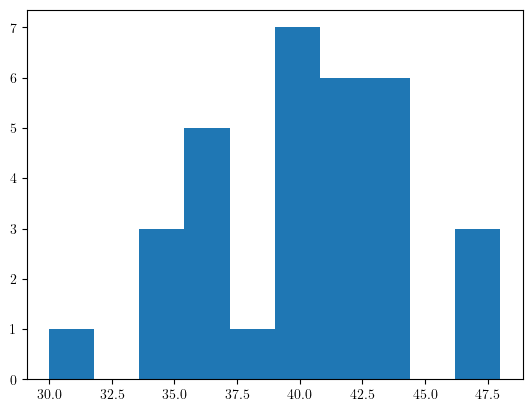

In [18]:
# our training parameters are roughly evently distributed throughout the partitions
plt.hist([len(x) for x in train_sorted])

In [19]:
lbounds, ubounds = bsp.get_sub_partition_bounds()
lower = np.tile(lower_bound, (size,1) )
lower[:, mask] = lbounds
upper = np.tile(upper_bound, (size,1) )
upper[:,mask] = ubounds

In [20]:
upper[:,0] = inv_transform(upper[:,0])

In [21]:
lower[:,0] = inv_transform(lower[:,0])

In [22]:
test[:,0] = inv_transform(test[:,0])
train[:,0]= inv_transform(train[:,0])

In [23]:
for partition in test_sorted:
    partition[:,0] = inv_transform(partition[:,0])
for partition in train_sorted:
    partition[:,0] = inv_transform(partition[:,0])

In [24]:
def make_sae(idx):
    partition_bounds = np.array([lower[idx, :], upper[idx, :]]).T
    training_partition = train_sorted[idx]
    for sample in training_partition:
        assert np.all(sample >= lower[idx, :]) and np.all(sample <= upper[idx, :])

    interactions = rose.koning_delaroche.EnergizedKoningDelaroche(
        partition_bounds,
        n_basis=10,
        l_max=15,
        method="least-squares",
        match_points=np.linspace(0.001, 6.1 * np.pi, 50),
        n_train=300,
    )
    sae = rose.ScatteringAmplitudeEmulator.from_train(
        interactions,
        training_partition,
        n_basis=20,
        angles=np.linspace(0, np.pi, 200),
        scale=True,
        use_svd=True,
    )
    return interactions, sae

In [25]:
saes = []
interactions = []

for i in range(0,bsp.size):
    inter, sae = make_sae(i)
    saes.append(sae)
    interactions.append(inter)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:12<00:00,  4.52s/it]
/home/kyle/umich/rose/src/rose/scattering_amplitude_emulator.py:354: RuntimeWarning: invalid value encountered in divide
  self.rutherford = 0.0 / (np.sin(self.angles / 2) ** 4)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:17<00:00,  4.84s/it]


In [26]:
ground_truth_solver =  rose.ScatteringAmplitudeEmulator.HIFI_solver(
            interactions[0],
            angles = np.linspace(0, np.pi, 200)
        )

In [27]:
def emulate_xs(sample):
    s = np.copy(sample)
    s[0] = transform(s[0])
    i = bsp.idx(s[mask])
    sae = saes[i]
    assert np.all(sample >= lower[i,:]) and np.all(sample <= upper[i,:])
    return sae.emulate_xs(sample)

In [28]:
x = saes[0].rbes[0][0].interaction.s_mesh
Ainv =saes[0].rbes[0][0].interaction.Ainv
y  =saes[0].rbes[0][0].interaction.tilde(x, test[0]).shape
saes[0].rbes[0][0].interaction.coefficients(test[0])

(0.9802442349200204,
 array([-15606.07240348+68766.13585367j,  10173.25747465-46195.70825173j,
         46426.62311506-89652.0038549j , -60558.54736644+74248.49026054j,
         38591.91550403-34556.52895032j,    681.90691018-11522.91118303j,
         33383.78280356-16784.88403984j, -42827.64509983+25734.17788392j,
        -27475.59824147-14530.49615781j,   7887.12171845 -1987.253158j  ]))

In [29]:
ground_truth = []
for sample in tqdm(test):
    ground_truth.append(ground_truth_solver.exact_xs(sample))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [06:29<00:00,  1.22s/it]


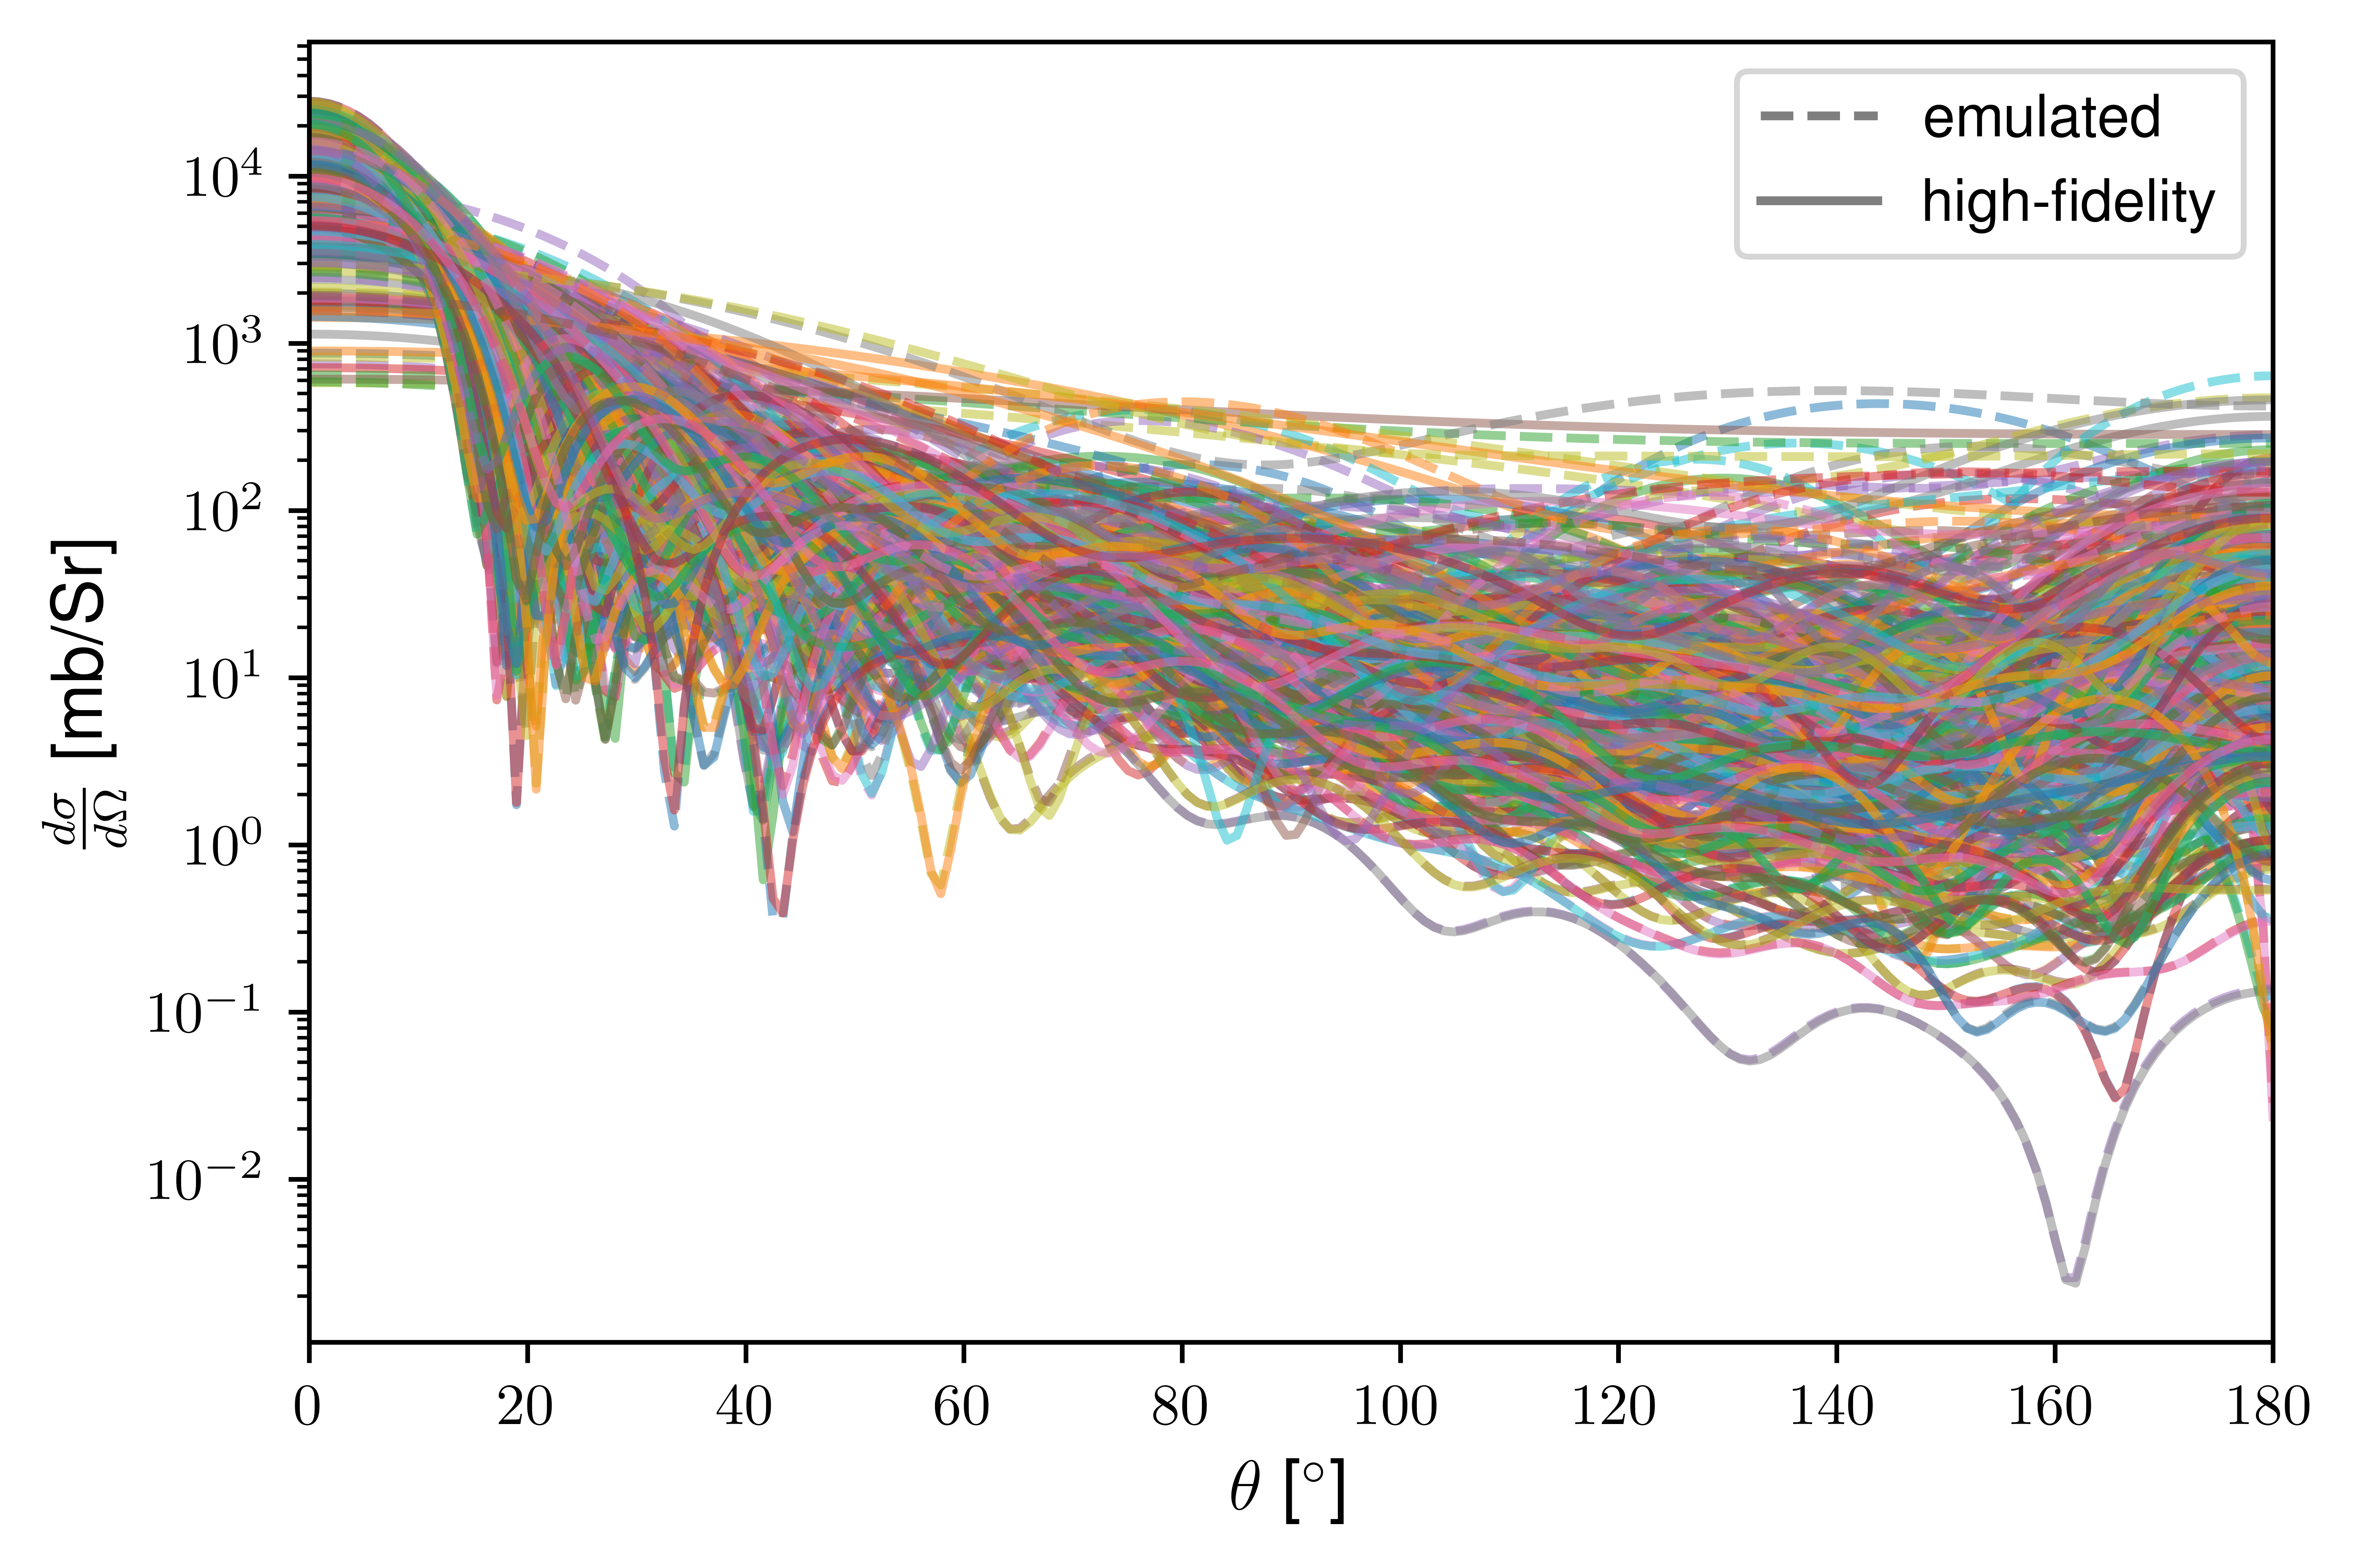

In [30]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(6, 4), dpi=1000)
fig.patch.set_facecolor("white")

for i, sample in enumerate(test[3:]):
    x = ground_truth_solver.angles * 180 / (np.pi)

    # HIFI
    y_exact = ground_truth[i].dsdo

    # emulated
    y_emu = emulate_xs(sample).dsdo

    p = ax.plot(x, y_emu, "--", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["emulated", "high-fidelity"])
ax.set_yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]", fontsize=12)
plt.ylabel(r"$\frac{d \sigma}{d\Omega}$ [mb/Sr]", fontsize=12)
plt.savefig("dsdo.pdf")

In [31]:
A, Z, El = (141, 55, "Xe")
egrid = np.linspace(0.2, 49, 100)
omp = rose.koning_delaroche.KDGlobal(rose.Projectile.neutron)

In [32]:
%%time
xs_rxn_emu = np.zeros_like(egrid)
xs_t_emu = np.zeros_like(egrid)
for i,e in tqdm(enumerate(egrid), total=egrid.size):
    (mu, E_com, _, _, _), params = omp.get_params(A, Z, E_com=e)
    xs_emu = emulate_xs(np.array([E_com, mu, *params]))
    xs_rxn_emu[i] = xs_emu.rxn
    xs_t_emu[i] = xs_emu.t

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.04it/s]

CPU times: user 8.94 s, sys: 21.5 s, total: 30.4 s
Wall time: 4.16 s


In [33]:
%%time
xs_rxn = np.zeros_like(egrid)
xs_t = np.zeros_like(egrid)
alphas = []
for i,e in tqdm(enumerate(egrid), total=egrid.size):
    (mu, E_com, _, _, _), params = omp.get_params(A, Z, E_com=e)
    alphas.append( np.array((E_com, mu, *params)) )
    xs = ground_truth_solver.exact_xs(alphas[i])
    xs_rxn[i] = xs.rxn
    xs_t[i] = xs.t

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]

CPU times: user 2min 3s, sys: 865 ms, total: 2min 3s
Wall time: 2min 2s


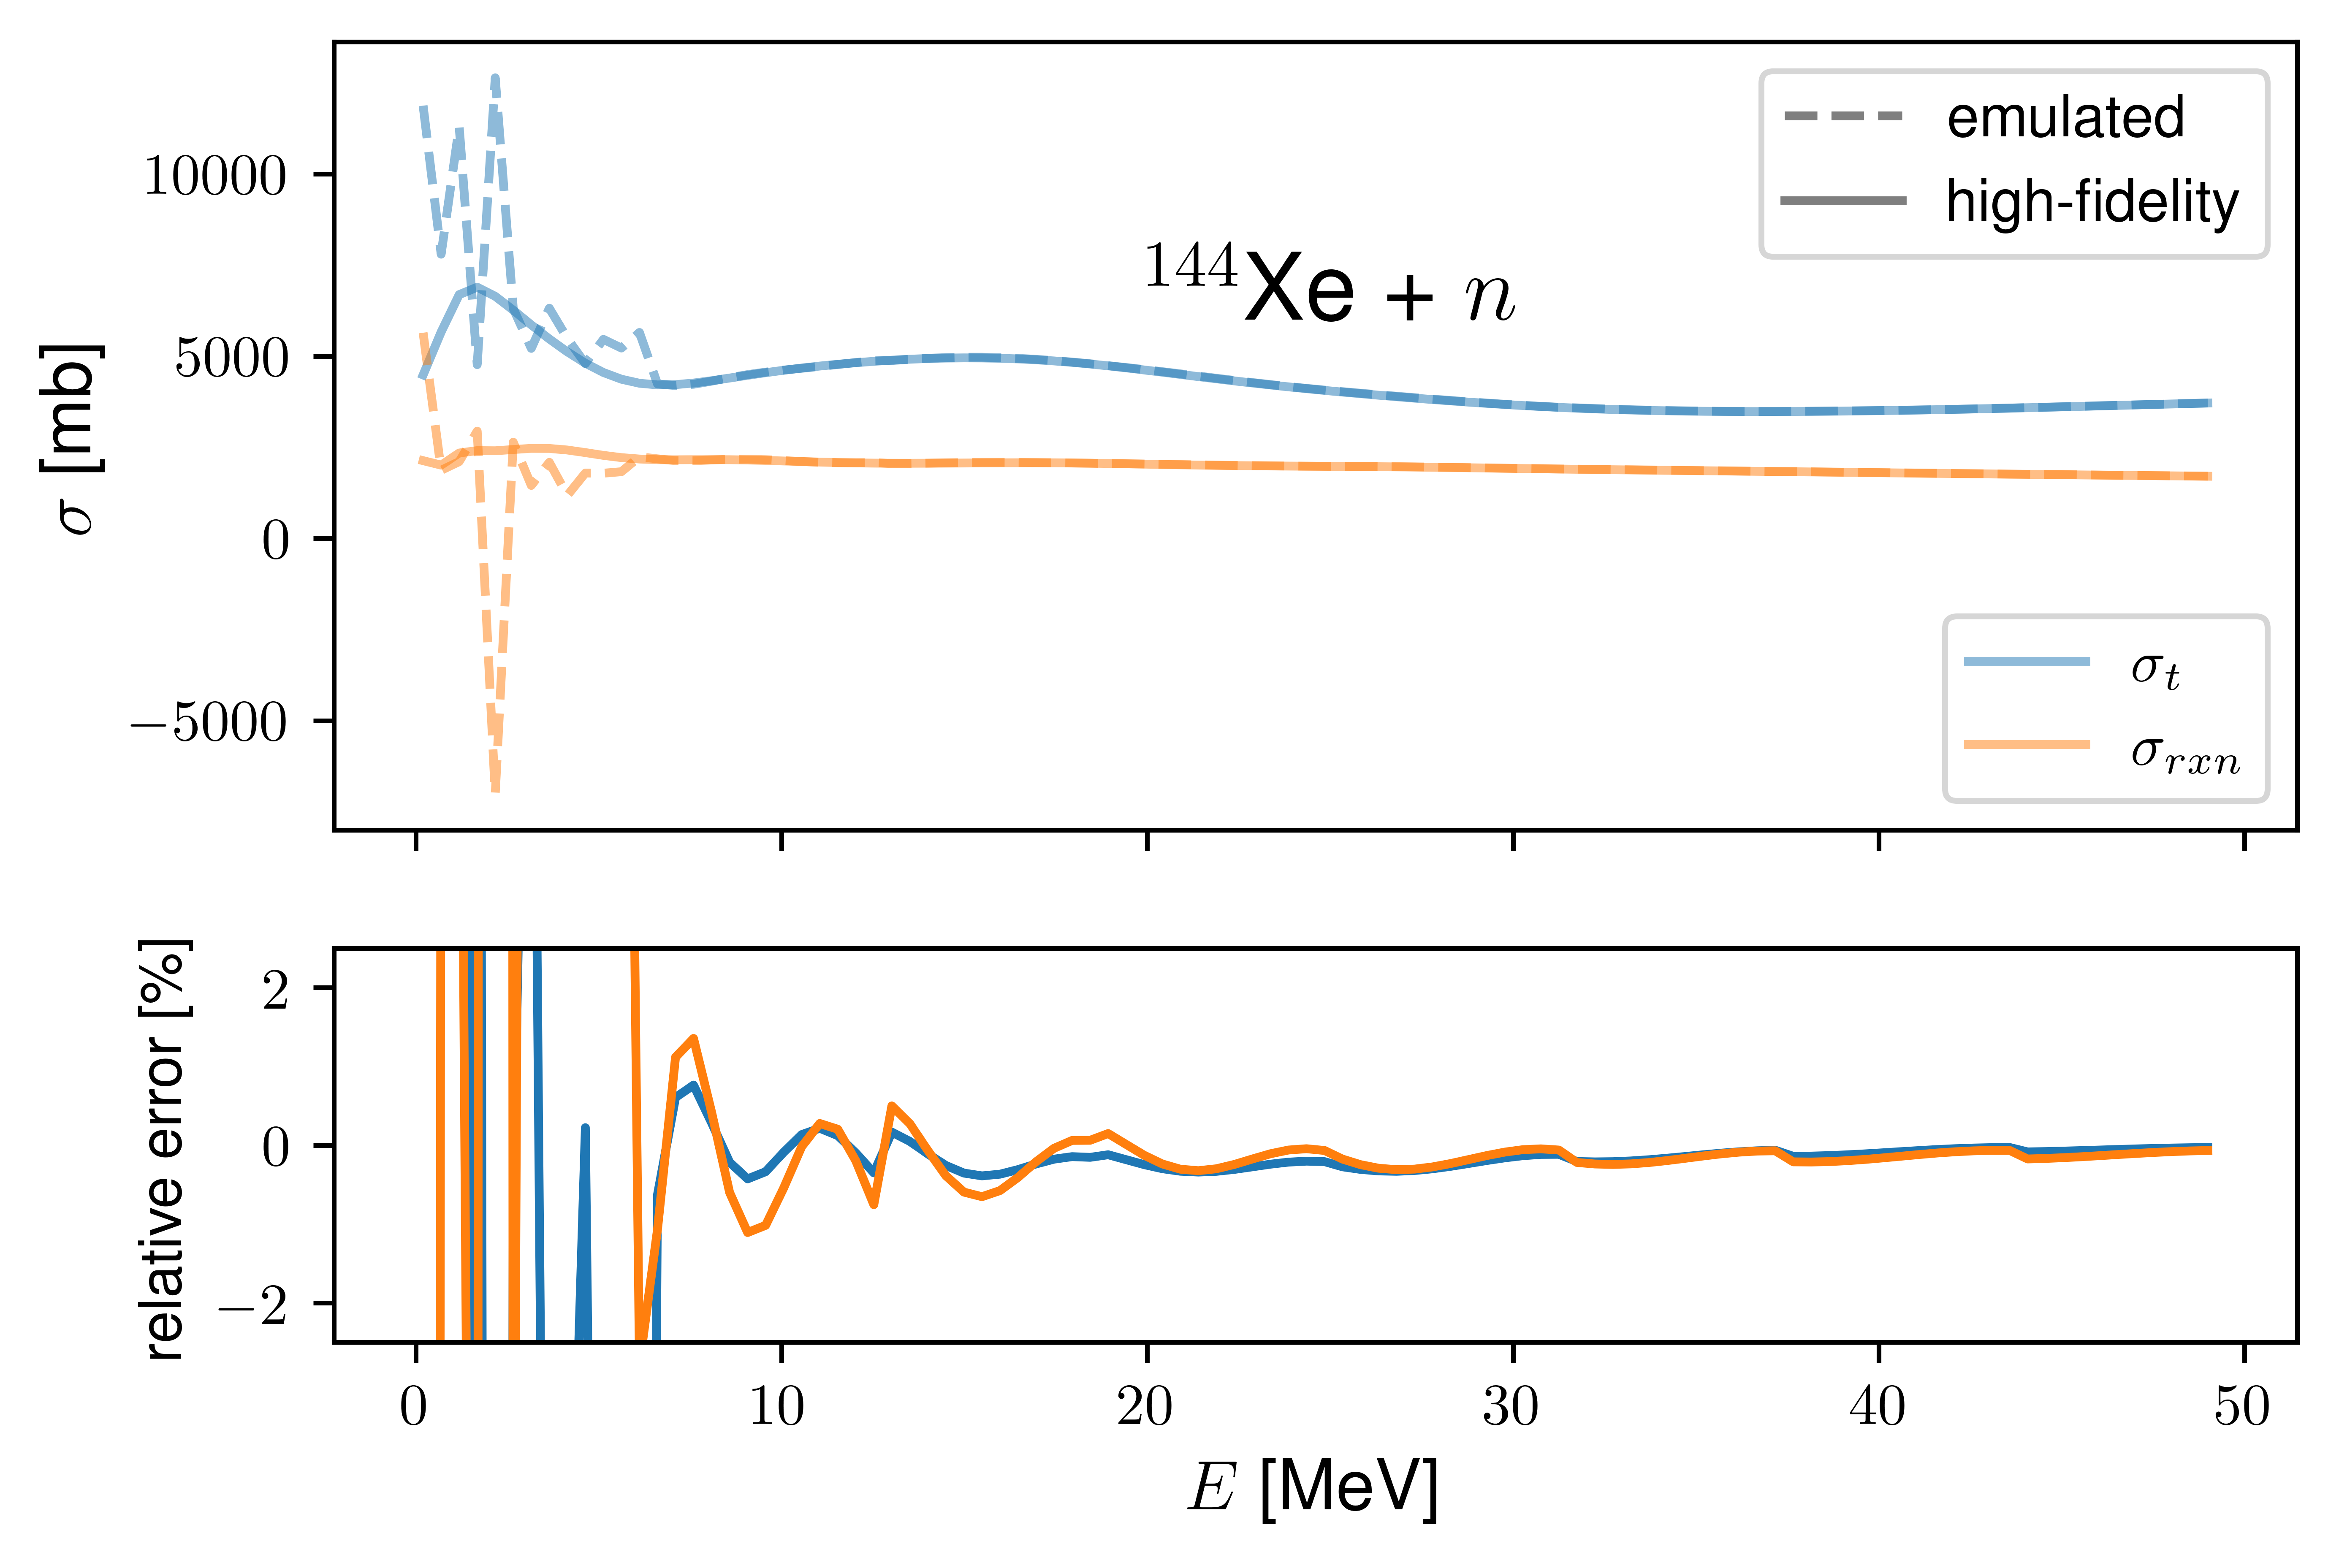

In [34]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=[1, 0.5], figsize=(6, 4), dpi=1000)
fig.patch.set_facecolor("white")

pt = ax1.plot(egrid, xs_t_emu, "--", alpha=0.5)
ax1.plot(egrid, xs_t, color=pt[0].get_color(), alpha=0.5)

prxn = ax1.plot(egrid, xs_rxn_emu, "--", alpha=0.5)
ax1.plot(egrid, xs_rxn, color=prxn[0].get_color(), alpha=0.5)

xs_styles = [
    Line2D([0], [0], color=pt[0].get_color(),  alpha=0.5),
    Line2D([0], [0], color=prxn[0].get_color(), alpha=0.5),
]

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--",alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
leg2 = ax1.legend(legend_styles, [r"emulated", r"high-fidelity"])
ax1.add_artist(leg2)
ax1.legend(xs_styles, [r"$\sigma_t$", r"$\sigma_{rxn}$"], loc="lower right")

ax1.text(20, 6000, r"$^{144}$Xe + $n$", fontsize=16)
plt.xlabel(r"$E$ [MeV]", fontsize=12)
ax1.set_ylabel(r"$\sigma$ [mb]", fontsize=12)

ax2.plot( egrid, 100*(xs_t - xs_t_emu)/xs_t , color=pt[0].get_color() )
ax2.plot( egrid, 100*(xs_rxn - xs_rxn_emu)/xs_rxn , color=prxn[0].get_color() )

ax2.set_ylabel(r"relative error [\%]")
ax2.set_ylim([-2.5,2.5])

plt.savefig("sigma_rxn_t_err.pdf")

In [35]:
# 1. calculate solutions uniformly over space
# 2. determine regions of maximum gradient
# 3. augment uniform samples 
# 

In [36]:
# make chart of isotopes colored with L2 error norm

In [37]:
# show singular vals for each sub-partition vs full space